## Problem statement:
Build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

In [2]:
data_dir_train = pathlib.Path(r"C:\Users\vivek\Downloads\archive\Skin cancer ISIC The International Skin Imaging Collaboration\Train")
data_dir_test = pathlib.Path(r"C:\Users\vivek\Downloads\archive\Skin cancer ISIC The International Skin Imaging Collaboration\Test")

In [3]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2194
16


**Data Visualization**

Found 8194 files belonging to 2 classes.


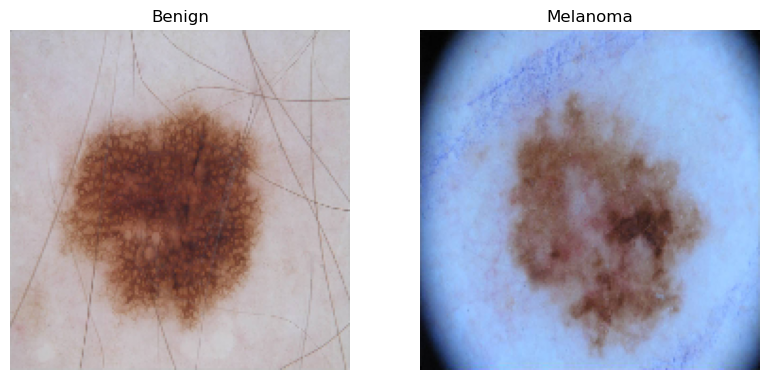

In [4]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

**Visualize distribution of classes in the training dataset.**

In [5]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,Benign,1739
1,Melanoma,455


C:\Users\vivek\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\vivek\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\vivek\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='No. of Image', ylabel='Class'>

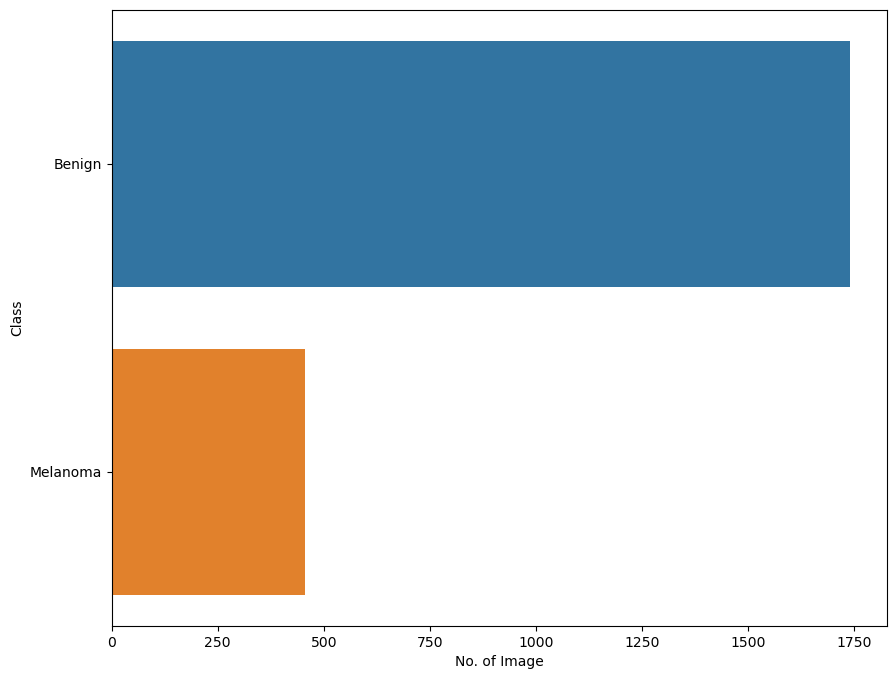

In [6]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

There is a class imbalance to solve this using a python package  Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [7]:
#install Augmentor
!pip install Augmentor

In [8]:
import Augmentor
import os
import warnings

warnings.filterwarnings('ignore')

# Define the path to your training dataset
training_dataset_path = r"C:\Users\vivek\Downloads\archive\Skin cancer ISIC The International Skin Imaging Collaboration\Train"

# Define a list of class names (subdirectories)
class_names = ["Melanoma","Benign"]

# Create an output directory for augmented images
#output_directory = os.path.join(training_dataset_path, "output")

# Check if the output directory exists, and create it if not
#if not os.path.exists(output_directory):
    #os.makedirs(output_directory)

# Loop through the class names and create Augmentor pipelines
for i in class_names:
    # Create an Augmentor pipeline with the path to the directory
    p = Augmentor.Pipeline(os.path.join(training_dataset_path, i))
    
    # Define the output directory for this class
    class_output_directory = os.path.join(training_dataset_path, i)
    
    # Check if the class's output directory exists, and create it if not
    if not os.path.exists(class_output_directory):
        os.makedirs(class_output_directory)
    
    # Apply augmentation operations to the images
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
    
    # Sample and augment images for this class
    p.sample(500, multi_threaded=True)

Initialised with 455 image(s) found.
Output directory set to C:\Users\vivek\Downloads\archive\Skin cancer ISIC The International Skin Imaging Collaboration\Train\Melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x216B19E4F50>: 100%|█| 500/500 [00:10<00:00, 49.62 Samples


Initialised with 1739 image(s) found.
Output directory set to C:\Users\vivek\Downloads\archive\Skin cancer ISIC The International Skin Imaging Collaboration\Train\Benign\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x216B1B1C910>: 100%|█| 500/500 [00:04<00:00, 116.98 Samples


In [9]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

7000


**Model Building**

In [10]:
# train dataset 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='binary',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 9194 files belonging to 2 classes.
Using 7356 files for training.


In [11]:
# validation dataset 
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,batch_size=32,
                                                            image_size=(180,180), label_mode='binary',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 118 files belonging to 2 classes.
Using 23 files for validation.


In [12]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Sequential allows you to create models layer-by-layer
model = Sequential()

# Add a Rescaling layer to scale pixel values to [0, 1]
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

# First Convolution layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Second Convolution Layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Third Convolution Layer
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Reduce the dropout rate in the following line
model.add(Dropout(0.25))

# Flatten Layer
model.add(Flatten())

# Dense Layers with Batch Normalization
model.add(Dense(128, activation='relu'))
model.add(layers.BatchNormalization())

model.add(Dense(64, activation='relu'))
model.add(layers.BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(layers.BatchNormalization())

# Reduce the dropout rate in the following line
model.add(Dropout(0.25))

# Dense Layer with sigmoid activation
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

In [14]:
model.save(r"C:\Users\vivek\Downloads\archive\Skin cancer ISIC The International Skin Imaging Collaboration\melanoma.h5")

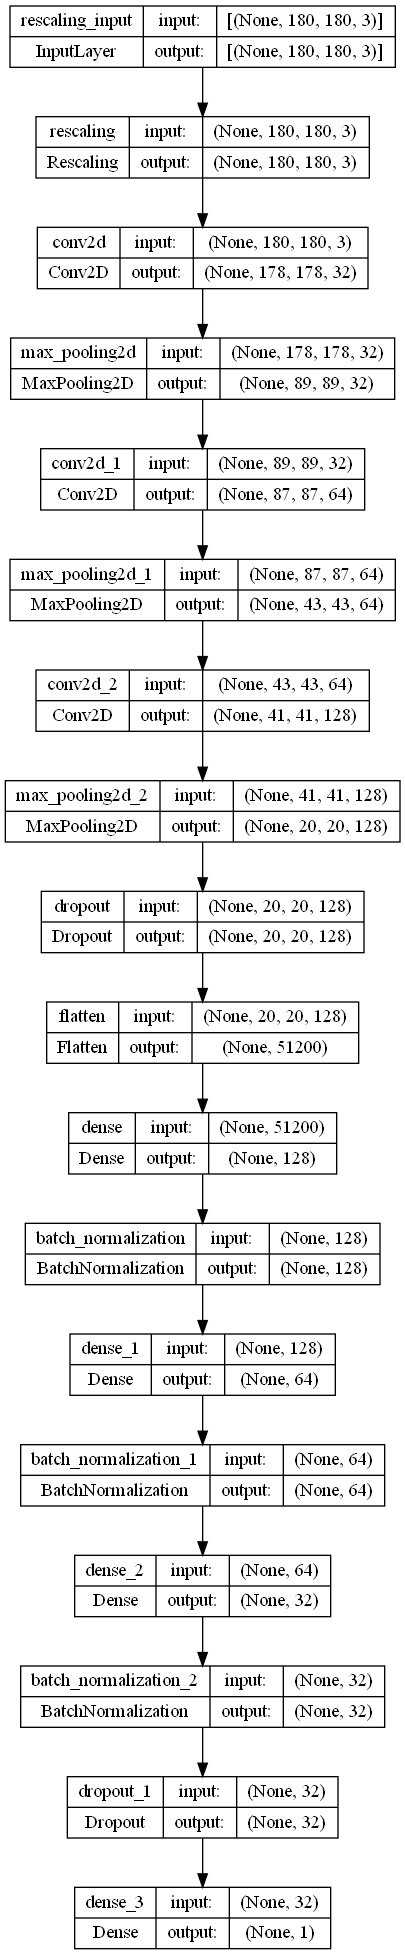

In [15]:
from tensorflow.keras.utils import plot_model
import Levenshtein
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [16]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="binary_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint(r"C:\Users\vivek\Downloads\archive\Skin cancer ISIC The International Skin Imaging Collaboration\melanoma.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_loss",patience=5,mode="min",verbose=1)

In [18]:
# Train the model
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/10
205/205 [==============================] - ETA: 0s - loss: 0.4961 - accuracy: 0.7843
Epoch 1: val_accuracy improved from -inf to 0.30435, saving model to C:\Users\vivek\Downloads\archive\Skin cancer ISIC The International Skin Imaging Collaboration\melanoma.h5
205/205 [==============================] - 138s 627ms/step - loss: 0.4961 - accuracy: 0.7843 - val_loss: 2.0861 - val_accuracy: 0.3043
Epoch 2/10
205/205 [==============================] - ETA: 0s - loss: 0.4498 - accuracy: 0.8046
Epoch 2: val_accuracy improved from 0.30435 to 0.56522, saving model to C:\Users\vivek\Downloads\archive\Skin cancer ISIC The International Skin Imaging Collaboration\melanoma.h5
205/205 [==============================] - 128s 623ms/step - loss: 0.4498 - accuracy: 0.8046 - val_loss: 0.9836 - val_accuracy: 0.5652
Epoch 3/10
205/205 [==============================] - ETA: 0s - loss: 0.4174 - accuracy: 0.8167
Epoch 3: val_accuracy improved from 0.56522 to 0.82609, saving model to C:\Users\vivek\

In [19]:
model.save(r"C:\Users\vivek\Downloads\archive\Skin cancer ISIC The International Skin Imaging Collaboration\model.h5")

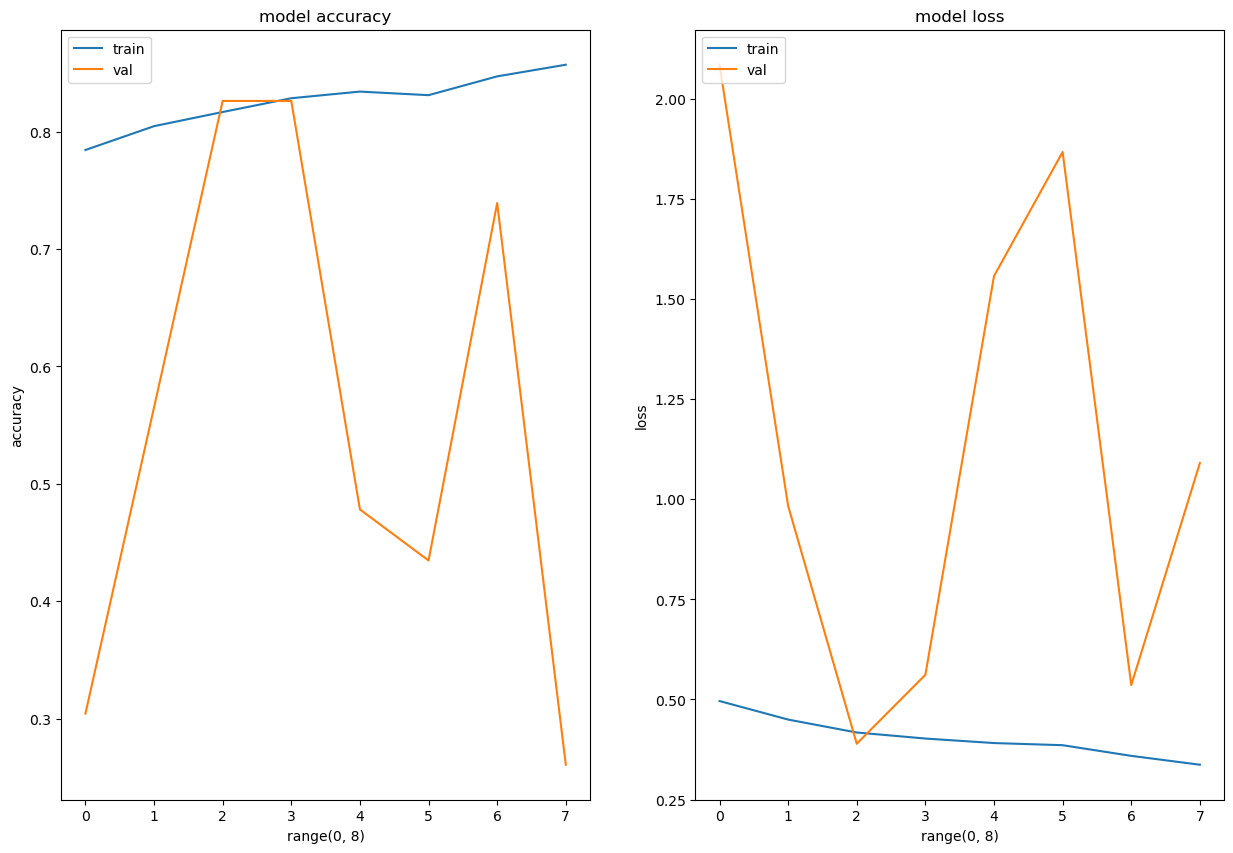

In [20]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()


## Model Prediction

1/1 [==============================] - 0s 230ms/step
The input image is classified as: Benign


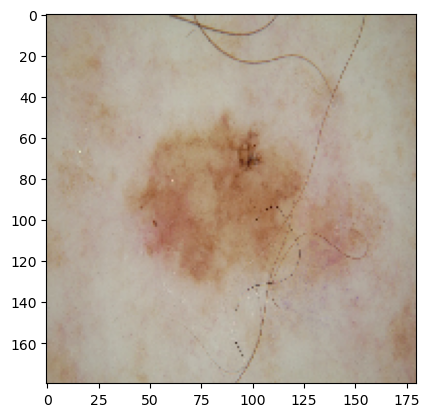

In [17]:
from glob import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
# Define the new path to the image you want to input
new_image_path = r"C:\Users\vivek\Downloads\archive\Skin cancer ISIC The International Skin Imaging Collaboration\Test\Not a melanoma\seborrheic keratosis\ISIC_0010808.jpg"

# Load the new image
new_image = load_img(new_image_path, target_size=(180, 180, 3))

# Display the new image
plt.imshow(new_image)
plt.grid(False)
model_path = r"C:\Users\vivek\Downloads\archive\Skin cancer ISIC The International Skin Imaging Collaboration\model.h5"

# Load the saved model
model = tf.keras.models.load_model(model_path)
# Preprocess the image for prediction
img = np.expand_dims(new_image, axis=0)
class_names=["Melanoma","Benign"]
# Make a prediction using your model
pred = model.predict(img)

#print(pred_class)
if pred > 0.5:
    print("The input image is classified as: Melanoma")
else:
    print("The input image is classified as: Benign")


1/1 [==============================] - 0s 158ms/step
The input image is classified as: Melanoma


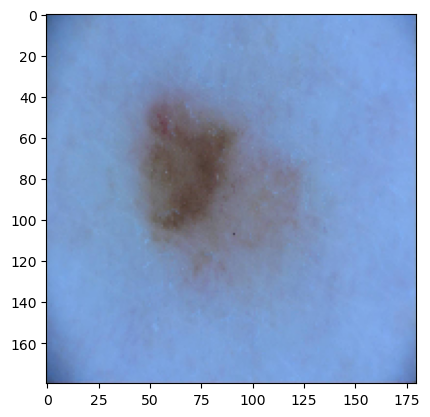

In [18]:
from glob import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
# Define the new path to the image you want to input
new_image_path = r"C:\Users\vivek\Downloads\archive\Skin cancer ISIC The International Skin Imaging Collaboration\Test\melanoma\ISIC_0000040.jpg"
# Load the new image
new_image = load_img(new_image_path, target_size=(180, 180, 3))

# Display the new image
plt.imshow(new_image)
plt.grid(False)
model_path = r"C:\Users\vivek\Downloads\archive\Skin cancer ISIC The International Skin Imaging Collaboration\model.h5"

# Load the saved model
model = tf.keras.models.load_model(model_path)
# Preprocess the image for prediction
img = np.expand_dims(new_image, axis=0)
class_names=["Melanoma","Benign"]
# Make a prediction using your model
pred = model.predict(img)

#print(pred_class)
if pred> 0.5:
    print("The input image is classified as: Melanoma")
else:
    print("The input image is classified as: Benign")
